In [6]:
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from segger_tracker import SeggerTracker
import ncolor
import glob
import re


In [4]:
excel_path = "/Users/sherryyang/Documents/wiggins-lab/data/manually_linked.xlsx"
excel_file = pd.ExcelFile(excel_path)
sheet_names = excel_file.sheet_names

In [21]:
pattern = r"211121_37C_10_1176_HU_timelapse002_prob211203_HU_t0+(\d+)xy0c1_seg.npy"

masks_set = {}

npzFiles = glob.glob("/Users/sherryyang/Documents/wiggins-lab/data/0820/xy0/phase/*.npy")
for f in npzFiles:
    match = re.search(pattern, f)
    
    dat = np.load(f, allow_pickle=True).item()
    gradientsx = np.gradient(dat['flows'][-1][0])
    gradientsy = np.gradient(dat['flows'][-1][1])
    gradient_total = gradientsy[1] + gradientsx[0]

    masks_set[f"t{str(match.group(1))}"] = regs_label = dat['masks']


In [8]:
masks_set

{"t<re.Match object; span=(60, 128), match='211121_37C_10_1176_HU_timelapse002_prob211203_HU_>": array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)}

In [89]:
df_sets = {}
# Normal process
for time_sheet in sheet_names:
    df = excel_file.parse(time_sheet)
    df = df.astype(str)
    df_copy = df.copy()

    df['area_overlap'] = None
    df['area_overlap_ratio'] = None

    columns = df.columns
    for index, row in df.iterrows():

        if ',' in row[columns[1]] or 'x' in row[columns[1]] or 'X' in row[columns[1]] or 'x' in row[columns[0]]:
            continue
        else:
            label1 = row[columns[0]]
            label2 = row[columns[1]]
            area_overlap = np.sum((masks_set[columns[0]] == int(label1)) * (masks_set[columns[1]] == int(label2)))
            area_initial = np.sum(masks_set[columns[0]] == int(label1))
            area_overlap_ratio = area_overlap / area_initial

            df_copy.at[index, 'area_overlap'] = area_overlap
            df_copy.at[index, 'area_overlap_ratio'] = area_overlap_ratio
            df_copy.at[index, 'area_initial'] = area_initial
    
    df_sets[time_sheet]=df_copy

In [37]:
#np.sum((masks_set['t10'] == 3) * (masks_set['t11'] == 16))
np.sum((masks_set['t10'] == 3))

2972

In [15]:
masks_set.keys()

dict_keys(["t<re.Match object; span=(60, 128), match='211121_37C_10_1176_HU_timelapse002_prob211203_HU_>"])

In [109]:
df_sets['t11-t12']

,t11,t12,area_overlap,area_overlap_ratio,area_initial
0,16,33,3097.0,0.978206,3166.0
1,19,"38,36",NaN,NaN,NaN
2,20,37,3921.0,0.967432,4053.0
3,24,41,4190.0,0.989141,4236.0
4,14,32,820.0,0.906077,905.0
5,18,35,2014.0,0.990654,2033.0
6,17,34,2568.0,0.984285,2609.0
7,21,39,2980.0,0.984148,3028.0
8,25,42,2208.0,0.990579,2229.0
9,26,43,1970.0,0.987964,1994.0


In [76]:
from scipy.stats import beta
def poisson_pmf(k, lamb):
    return poisson.pmf(k, lamb)

In [77]:
def beta_pdf(x, a, b):
    return beta.pdf(x, a, b)

In [87]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson
from scipy.optimize import curve_fit

def save_img(data, label):
    bin_edges = np.arange(0, 1.01, 0.01)

    list=[]
    for i in range(1,len(bin_edges)):
        list.append((bin_edges[i-1] + bin_edges[i] ) / 2)

    y_data = np.histogram(data, bins=bin_edges)[0]

    popt, _ = curve_fit(beta_pdf, list, y_data)
    a_fit, b_fit = popt
    y_fit = beta_pdf(bin_edges, a_fit, b_fit)

    plt.hist(data, bins=bin_edges, color='blue', edgecolor='black', label='Overlap Ratio Distribution')
    plt.plot(bin_edges, y_fit, 'r-', label='Fitted Poisson Distribution')

    plt.legend()
    plt.savefig(f"/Users/sherryyang/Documents/wiggins-lab/data/overlap-stat/{label}.png")
    plt.clf()

In [88]:
for key, value in df_sets.items():
    data = value['area_overlap_ratio']
    save_img(data, key)

<Figure size 640x480 with 0 Axes>

In [157]:
df = df_sets['t1-t2']

def draw_area_ratio_relationship(df, label):
    df= df.dropna()

    area_initial = df['area_initial']
    area_overlap_ratio = df['area_overlap_ratio']
    
    plt.scatter(area_initial, area_overlap_ratio)
    

    plt.ylim(-0.2,1.2)
    plt.xlim(-2000,12000)

    plt.axhline(0, color='green', linestyle='--', label='Vertical Line')
    plt.axhline(1, color='green', linestyle='--', label='Vertical Line')
    plt.axvline(0, color='green', linestyle='--', label='Vertical Line')


    plt.xlabel("Original Area")
    plt.ylabel("Overlap Area Ratio")

    plt.title(label)
    plt.savefig(f"/Users/sherryyang/Documents/wiggins-lab/data/overlap-relationship/{label}.png")
    plt.clf()



In [158]:
for key, value in df_sets.items():
    draw_area_ratio_relationship(value, key)

<Figure size 640x480 with 0 Axes>

In [137]:
x = []
y = []
for key, value in df_sets.items():
    df = value.dropna()
    x.extend(np.array(df['area_initial']))
    y.extend(np.array(df['area_overlap_ratio']))
    draw_area_ratio_relationship(value, key)

<Figure size 640x480 with 0 Axes>

In [ ]:
"""
    slope, intercept = np.polyfit(area_initial, area_overlap_ratio, 1)

    fit_x = np.array([np.min(area_initial), np.max(area_initial)])
    fit_y = slope * fit_x + intercept
    plt.plot(fit_x, fit_y, color='grey')
    
"""

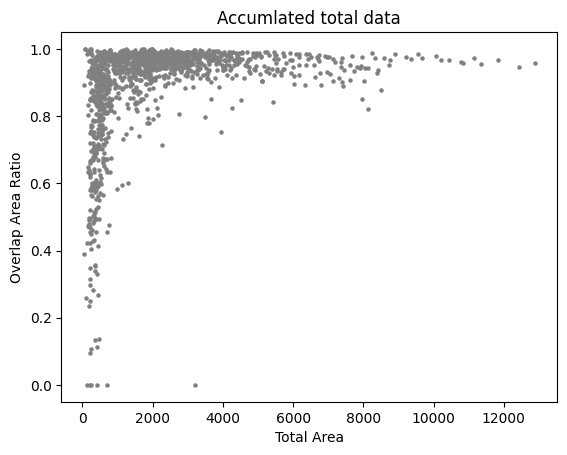

In [150]:
plt.scatter(x, y, s=5, color = 'grey')
plt.xlabel("Total Area")
plt.ylabel("Overlap Area Ratio")
plt.title('Accumlated total data')
plt.savefig('/Users/sherryyang/Documents/wiggins-lab/data/master.png')

Text(0.5, 1.0, 'Accumlated total data (log x)')

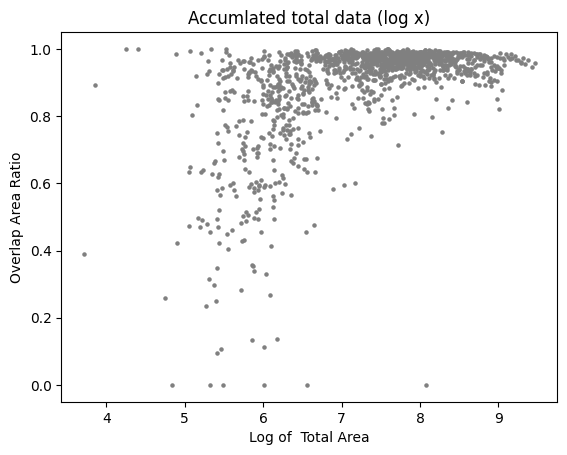

In [155]:
plt.scatter(np.log(x), y, s=5, color = 'grey')
plt.xlabel("Log of  Total Area")
plt.ylabel("Overlap Area Ratio")
plt.title('Accumlated total data (log x)')

/var/folders/tp/1bsthy355yj6qlmh5ym1996w0000gn/T/ipykernel_90989/409579463.py:1: RuntimeWarning: divide by zero encountered in log
  plt.scatter(x, np.log(y), s=5, color = 'grey')


Text(0.5, 1.0, 'Accumlated total data (log y)')

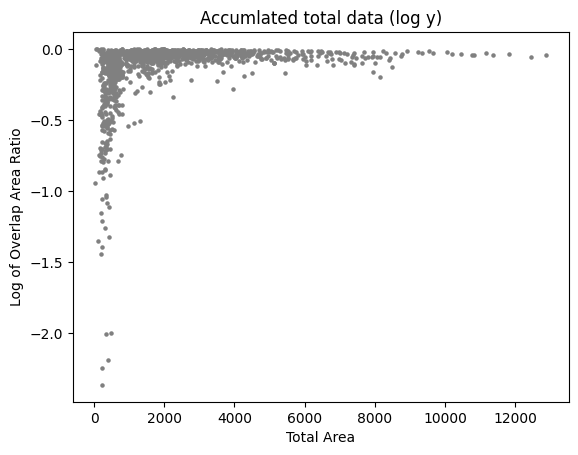

In [156]:
plt.scatter(x, np.log(y), s=5, color = 'grey')
plt.xlabel("Total Area")
plt.ylabel("Log of Overlap Area Ratio")
plt.title('Accumlated total data (log y)')